# Import libraries



In [ ]:
import os
import time
import torch
import numpy as np
from tqdm import tqdm
from skimage import io
from sklearn import preprocessing
from skimage.transform import rescale
%matplotlib inline
from matplotlib import pyplot as plt
from DICTOL_python.dictol import SRC, DLSI
from DICTOL_python.dictol.utils import randperm, label_to_range, get_block_col, normc

# Load Hand_Gesture_Recognition_Database and Compute feature vectors

In [105]:
scale_factor = 0.25

In [106]:
# Find out image dimension (it is assumed that all images have the same size)
# Read image
im_path = 'DICTOL_python/dictol/data/Hand Gesture Recognition Database/05_thumb/frame_00_05_0008.png'
im = io.imread(im_path)
im = rescale(im, scale_factor)
print(f'Image size: {im.shape}')

Image size: (60, 160)


In [107]:
class RP(torch.nn.Module):
    """Implementation of random image descriptor: random projection class"""
    
    def __init__(self, dim_in, dim_out, device='cpu'):
        """
        Constructor.

        Args:
            dim_in (int): input dimension of images. Note that we will flatten images of shape (W, H, 3) to (W * H * 3)
            dim_out (int): output dimension of image features.
            device (str, optional): use either 'cpu' or 'cuda' (gpu). Defaults to 'cpu'.
        """
        super(RP, self).__init__()
        
        # Save hyperparameters as attributes
        self.dim_in = dim_in
        self.dim_out = dim_out
        
        # Create normalized random Gaussian matrix with shape (dim_in, dim_out)
        self.proj_mat = torch.tensor(
            np.sqrt(dim_out) * np.random.randn(dim_in, dim_out)  # np.sqrt(dim_out) normalizes every column to 1
        ).float().unsqueeze(0).to(device)

    def compute_rp(self, X):
        """
        Compute random projections over X, where every row is data sample.

        Args:
            X (torch.tensor): input images with shape (B, 1, dim_in)

        Returns:
            torch.tensor: random descriptor with shape (B, 1, dim_out)
        """
        rp_feat = X @ self.proj_mat
        return rp_feat

In [108]:
class HGRDataset(torch.utils.data.Dataset):
    def __init__(self, path_list, label_list, scale_factor=1.0):
        self.path_list = path_list
        self.label_list = label_list
        self.scale_factor = scale_factor

    def __len__(self):
        return len(self.path_list)

    def __getitem__(self, idx):
        img = io.imread(self.path_list[idx])
        img = rescale(img, self.scale_factor, anti_aliasing=True)
        img = (img / 255.0) - 0.5
        img = img.astype(np.float32)
        label = self.label_list[idx]
        return img.flatten(), label


In [ ]:
def load_HGR_train_test(N_train_c, dim_feat=504, subsampling=[], scale_factor=1, batch_size=64, num_workers=4):
    # Arguments
    # - N_train_c: number of training images per class to learn/build dictionary.
    # - dim_feat: dimensionality of the random projected vectors.
    # - subsampling: reduce the number of samples in database using this subsampling factor.
    # - scale_factor: image scaling factor.
    
    path_list = []
    label_list = []
    dataset_path = os.path.abspath('DICTOL_python/dictol/data/Hand Gesture Recognition Database')

    for path, dirs, files in os.walk(dataset_path):
        dirs.sort()
        for file in sorted(files):
            if file.endswith(".png"):
                path_list.append(os.path.join(path, file))
                label = os.path.normpath(path).split(os.path.sep)[-1]
                label_list.append(label)

    if subsampling:
        total_samples = len(path_list)
        num_samples = int(subsampling / 100 * total_samples)
        ind = np.random.permutation(total_samples)
        path_list = [path_list[i] for i in ind[:num_samples]]
        label_list = [label_list[i] for i in ind[:num_samples]]
        print(f'Subsampling: {num_samples} of {total_samples} ({subsampling}%)')

    # Label encoding
    le = preprocessing.LabelEncoder()
    le.fit(label_list)
    label_int = le.transform(label_list) + 1

    # Order by label
    if subsampling:
        ord_ind = sorted(range(len(label_int)), key=lambda k: label_int[k])
        path_list = [path_list[i] for i in ord_ind]
        label_int = [label_int[i] for i in ord_ind]

    dataset = HGRDataset(path_list, label_int, scale_factor=scale_factor)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    print('Computing features via random projections...')
    first_sample, _ = dataset[0]
    rp = RP(dim_in=first_sample.shape[0], dim_out=dim_feat)
    feat_list = []
    
    i = 0
    progress_bar = tqdm(dataloader)
    for X_batch, _ in progress_bar:
        rp_feat = rp.compute_rp(X_batch).squeeze(0)
        feat_list.append(rp_feat)
        i += len(rp_feat)
        progress_bar.set_description(f"Processed {i} samples")

    Y = torch.cat(feat_list, dim=0).T.numpy()
    d = Y.shape[0]

    Y_range = np.array(label_to_range(label_int))
    C = Y_range.size - 1
    N_total = Y_range[-1]
    N_train = C * N_train_c
    N_test = N_total - N_train

    if N_test <= 0:
        raise Exception("Too many samples in the training subset. Reduce N_train_c.")

    Y_train = np.zeros((d, N_train))
    Y_test = np.zeros((d, N_test))
    label_train = [0] * N_train
    label_test = [0] * N_test
    cur_train = 0
    cur_test = 0

    for c in range(C):
        Yc = get_block_col(Y, c, Y_range)
        N_total_c = Yc.shape[1]
        N_test_c = N_total_c - N_train_c
        if N_test_c <= 0:
            raise Exception(f"Too many training samples for class {le.inverse_transform([c])[0]}")

        ids = randperm(N_total_c)
        label_train[cur_train:cur_train + N_train_c] = [c + 1] * N_train_c
        label_test[cur_test:cur_test + N_test_c] = [c + 1] * N_test_c

        Y_train[:, cur_train:cur_train + N_train_c] = Yc[:, np.sort(ids[:N_train_c])]
        Y_test[:, cur_test:cur_test + N_test_c] = Yc[:, np.sort(ids[N_train_c:])]

        cur_train += N_train_c
        cur_test += N_test_c

    Y_train = normc(Y_train)
    Y_test = normc(Y_test)

    return Y_train, label_train, Y_test, label_test, le, rp


In [78]:
N_train = 200  # Training images per class to build dictionary. Total training samples: N_train x Num classes
dim_feat = 1500  # Dimension of the image feature vectors
subsampling = []  # Percentage for subsampling the database sample and speed up the computational time. [] for use all samples

start = time.time()
Y_train, label_train, Y_test, label_test, le, rp = load_HGR_train_test(N_train, dim_feat=dim_feat, subsampling=subsampling, scale_factor=scale_factor)
end = time.time()

print(f'Elapse time for loading dataset and feature computation (s): {end - start}')
print(f'Num training images: {Y_train.shape[1]}')
print(f'Num test images: {Y_test.shape[1]}')
print(f'Class ids: {set(label_train)}')

Computing features via random projections...


Processed 20000 samples: 100%|██████████| 313/313 [00:21<00:00, 14.29it/s]


Elapse time for loading dataset and feature computation (s): 22.54231357574463
Num training images: 2000
Num test images: 18000
Class ids: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}


## Visualize feature vectors in a 2 subspace with t-sne

[Text(0.5, 1.0, 'Data T-SNE projection')]

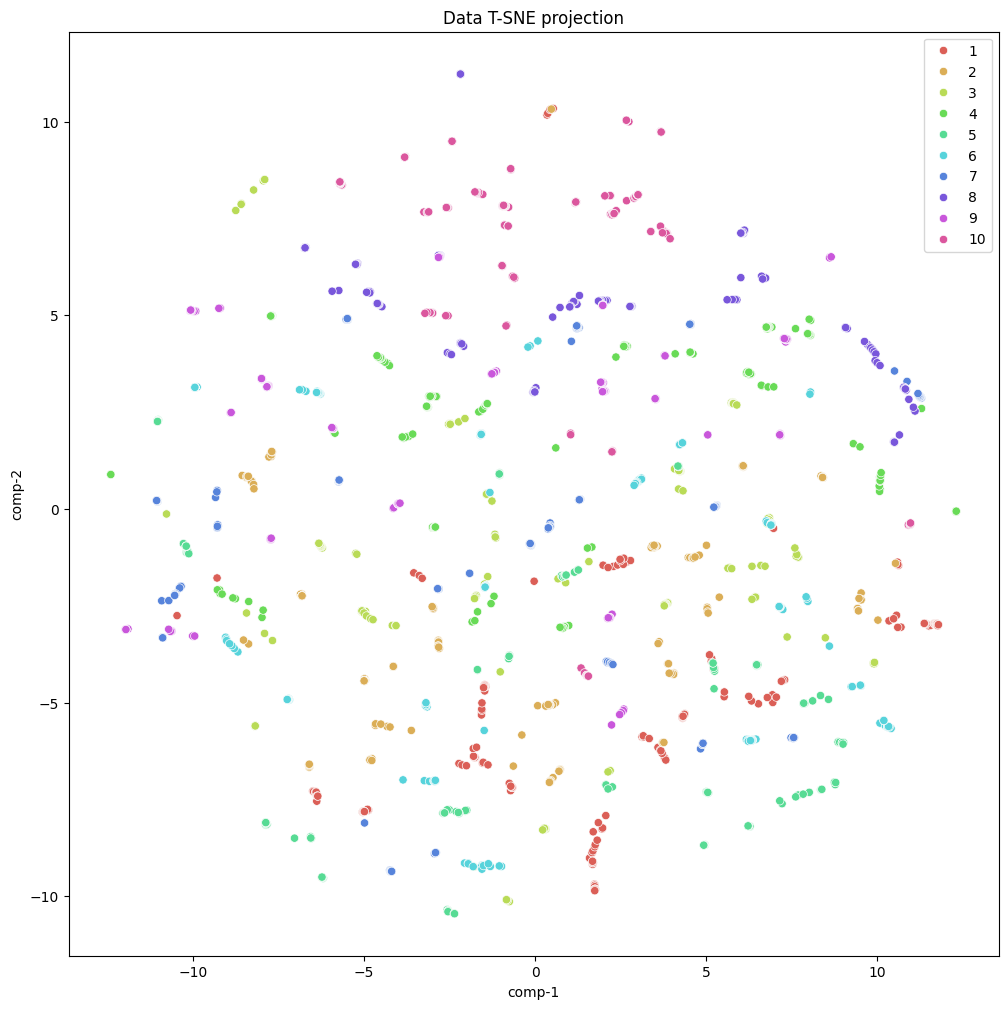

In [79]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

tsne = TSNE(random_state = 42, n_components=2,verbose=0, perplexity=40, n_iter=300)
z = tsne.fit_transform(Y_train.transpose())
df = pd.DataFrame()
df["y"] = label_train
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
fig = plt.figure(figsize = (12, 12))
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", len(set(label_train))),
                data=df).set(title="Data T-SNE projection")

# Sparse Representation-based Classification (SRC)

## Compute dictionary as the straightforward concatenation of features vector from images

In [80]:
src = SRC.SRC(lamb=0.99999975)  # Sparsity regularizer in the underlying lasso minimization problem. The optimal value can be very different for different applications and paramenters.
src.fit(Y_train, label_train)

print(f'Num Classes: {src.num_classes}')
print(f'Feature vector dimension: {src.D.shape[0]}')
print(f'Atoms in dictionary: {src.D.shape[1]}')

Num Classes: 10
Feature vector dimension: 1500
Atoms in dictionary: 2000


## Image Classification using SRC on test data

In [81]:
start = time.time()
pred = src.predict(Y_test, iterations=100, mean_spars=True)
end = time.time()

print(f'Elapse time for prediction(s): {end - start}')
acc = np.sum(pred == label_test) / float(len(label_test))
print('Accuracy = {:.2f} %'.format(100 * acc))

/home/dfc/projects/classes/bdivs/lab6/data/DICTOL_python/dictol/SRC.py:30: RuntimeWarning: invalid value encountered in divide
  cs_bin = cs/cs[-1,:] > threshold


Mean sparsity: 10.622055555555555 out of 2000
Std sparsity: 9.947137622743663
Elapse time for prediction(s): 38.3161678314209
Accuracy = 94.88 %


In [85]:
# Class names from prediction
if le:
  class_id = le.inverse_transform(np.asarray(label_test)-1)
  class_pred = le.inverse_transform(pred-1)
  print(f'Actual ids for the first five test samples: {class_id[0:5]}')
  print(f'Id predictions for the first five test samples: {class_pred[0:5]}')

Actual ids for the first five test samples: ['01_palm' '01_palm' '01_palm' '01_palm' '01_palm']
Id predictions for the first five test samples: ['01_palm' '01_palm' '01_palm' '01_palm' '01_palm']


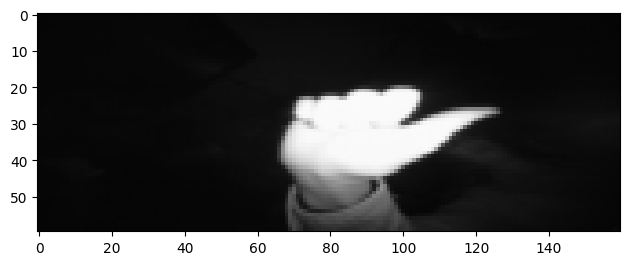

Actual id: 05_thumb
Predicted id: ['05_thumb']


In [ ]:
# Prediction over a specific image
im_path = 'DICTOL_python/dictol/data/Hand Gesture Recognition Database/05_thumb/frame_00_05_0008.png'
if rp:
    # Computes feature vector (RP) from image
    im = io.imread(im_path)
    im = rescale(im, scale_factor)
    io.imshow(im)
    plt.show()
    im = (im/255)-0.5
    im = im.flatten()
    im = torch.tensor(im, dtype=torch.float)
    rp_feat = rp.compute_rp(im).T.numpy()

    # Estimate label from folder name
    full_path = os.path.dirname(im_path)
    label = os.path.normpath(full_path).split(os.path.sep)[-1]
    print(f'Actual id: {label}')
    pred_one = src.predict(rp_feat, iterations=100)
    print(f'Predicted id: {le.inverse_transform(pred_one-1)}')



# Dictionary learning with structured incoherence (DLSI)

## Learn a dictionary from the training features vector obtained from images

In [ ]:
# lamda: Sparsity regularizer in the underlying lasso minimization problem.
# k: number of atoms per class in the dictionary
dlsi = DLSI.DLSI(k=32, lambd=0.0000001, eta=0.001)
start = time.time()
dlsi.fit(Y_train, label_train, iterations=100, verbose=True)
end = time.time()

print(f'Elapse time for dictionary learning(s): {end - start}')
print(f'Num Classes: {dlsi.num_classes}')
print(f'Feature vector dimension: {src.D.shape[0]}')
print(f'Atoms in dictionary: {dlsi.D.shape[1]}')

## Image Classification using DLSI on test data

In [101]:
start = time.time()
pred = dlsi.predict(Y_test, iterations=100, mean_spars=True)
end = time.time()

print(f'Elapse time for prediction(s): {end - start}')
acc = np.sum(pred == label_test) / float(len(label_test))
print('Accuracy = {:.2f} %'.format(100 * acc))

Mean sparsity: 28.0 out of 320
Std sparsity: 0.0
Elapse time for prediction(s): 5.771199941635132
Accuracy = 49.87 %


In [102]:
# Class names from prediction
if le:
  class_id = le.inverse_transform(np.asarray(label_test)-1)
  class_pred = le.inverse_transform(pred-1)
  print(f'Actual ids for the first five test samples: {class_id[0:5]}')
  print(f'Id predictions for the first five test samples: {class_pred[0:5]}')

Actual ids for the first five test samples: ['01_palm' '01_palm' '01_palm' '01_palm' '01_palm']
Id predictions for the first five test samples: ['08_palm_moved' '08_palm_moved' '08_palm_moved' '08_palm_moved'
 '08_palm_moved']


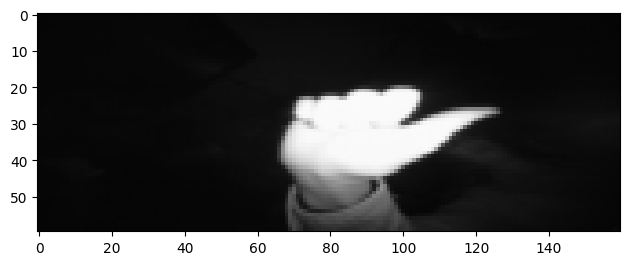

Actual id: 05_thumb
Predicted id: ['05_thumb']


In [ ]:
# Prediction over a specific image
im_path = 'DICTOL_python/dictol/data/Hand Gesture Recognition Database/05_thumb/frame_00_05_0008.png'
if rp:
    # Computes feature vector (RFF) from image
    im = io.imread(im_path)
    im = rescale(im, scale_factor)
    io.imshow(im)
    plt.show()
    im = (im/255)-0.5
    im = im.flatten()
    im = torch.tensor(im, dtype=torch.float)
    rp_feat = rp.compute_rp(im).T.numpy()

    # Estimate label from folder name
    full_path = os.path.dirname(im_path)
    label = os.path.normpath(full_path).split(os.path.sep)[-1]
    print(f'Actual id: {label}')
    pred_one = dlsi.predict(rp_feat, iterations=100)
    print(f'Predicted id: {le.inverse_transform(pred_one-1)}')